# Exploration of the data

#### Get path to the raw data

In [1]:
import os
from pathlib import Path

from dotenv import load_dotenv
load_dotenv()
root_data = os.getenv("KAGGLE_FILES_DIR")
dataset_path = Path(os.getcwd(), "..", root_data)
raw = Path(dataset_path, "raw")

#### Read CSVs files with labels

In [3]:
import pandas as pd

labels_traintest15_train19 = pd.read_csv(Path(raw, 'labels', 'traintestLabels15_trainLabels19.csv'), header=0, usecols=["image", "level"])
labels_train19 = pd.read_csv(Path(raw, 'labels', 'trainLabels19.csv'), header=0, usecols=["id_code", "diagnosis"])
labels_train19.rename(columns={"id_code": "image", "diagnosis": "level"}, inplace=True)  # rename columns to match other datasets

labels_train15 = pd.read_csv(Path(raw, 'labels', 'trainLabels15.csv'), header=0, usecols=["image", "level"])
labels_test15 = pd.read_csv(Path(raw, 'labels', 'testLabels15.csv'), header=0, usecols=["image", "level"])


#### Shapes of labels CSVs

In [4]:
print(labels_traintest15_train19.shape)
print(labels_train19.shape)
print(labels_train15.shape)
print(labels_test15.shape)

(92364, 2)
(3662, 2)
(35126, 2)
(53576, 2)


#### Concatenate all labels with no duplicates

In [5]:
labels = pd.concat([labels_traintest15_train19, labels_train19, labels_train15, labels_test15], ignore_index=True).drop_duplicates()
labels.shape

(92364, 2)

##### Looks like `labels_traintest15_train19` labels contains all unique data.

#### Check images directories length

In [6]:
imgs_15 = Path(raw, 'resized_traintest15_train19')
imgs_19 = Path(raw, 'resized_test19')

print(len(list(imgs_15.glob("*"))))
print(len(list(imgs_19.glob("*"))))


92364
1928


#### Check if `traintestLabels15_trainLabels19.csv` contains all images from `resized_traintest15_train19`.

In [ ]:
missing = []

for label in labels[["image"]].values:
    p = Path(imgs_15, f"{label[0]}.jpg")
    if not p.exists():
        missing.append(label)
        print(f"Image {label[0]} not found in `resized_traintest15_train19`")

#### All images from `traintestLabels15_trainLabels19.csv` are present in `resized_traintest15_train19`.
#### Other CSVs and resized_test19 directory are not removed.

In [25]:
import shutil
shutil.rmtree(imgs_19)
shutil.move(imgs_15, Path(raw, "images"))
labels.to_csv(Path(raw, "labels.csv"), index=False)
shutil.rmtree(Path(raw, "labels"))

#### Make dirs for clases of data
I will simplify images into 2 categories - healthy (0) and non-healthy (DR for diabetic retinopathy, 1)

In [36]:
retinopathy_severity = {
    0: 0,
    1: 1,
    2: 1,
    3: 1,
    4: 1
}
for severity in retinopathy_severity.values():
    os.makedirs(Path(raw, str(severity)), exist_ok=True)

#### Move images to their classes

In [40]:
from tqdm import tqdm
images = Path(raw, "images")


# Map the 'level' column in the labels DataFrame using the retinopathy_severity dictionary
labels['level'] = labels['level'].map(retinopathy_severity)

for image in tqdm(images.glob("*")):
    label = labels[labels["image"] == image.stem]["level"].values[0]
    shutil.move(image, Path(raw, retinopathy_severity[label], image.name))

shutil.rmtree(images)

0it [00:00, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/Users/isulim/Sages/retino-cnn/notebooks/../data/raw/images'

#### Split images into train, validation and test sets (80%/10%/10%)

In [54]:
import splitfolders

processed = Path(dataset_path, 'processed')
os.makedirs(processed, exist_ok=True)

splitfolders.ratio(raw, output=processed, seed=42, ratio=(0.8, 0.1, 0.1))

Copying files: 92364 files [00:58, 1584.17 files/s]


# Create train, validation, test datasets

In [2]:
import os
from pathlib import Path

from dotenv import load_dotenv
load_dotenv()
root_data = os.getenv("KAGGLE_FILES_DIR")
dataset_path = Path(os.getcwd(), "..", root_data)

In [3]:
import torchvision

processed = Path(dataset_path, 'processed')
train_dataset = torchvision.datasets.ImageFolder(root=str(Path(processed, 'train')), transform=None)
val_dataset = torchvision.datasets.ImageFolder(root=str(Path(processed, 'val')), transform=None)
test_dataset = torchvision.datasets.ImageFolder(root=str(Path(processed, 'test')), transform=None)

In [4]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

73890
9235
9239


## Explore image sizes

100%|██████████| 7389/7389 [01:41<00:00, 73.13it/s] 


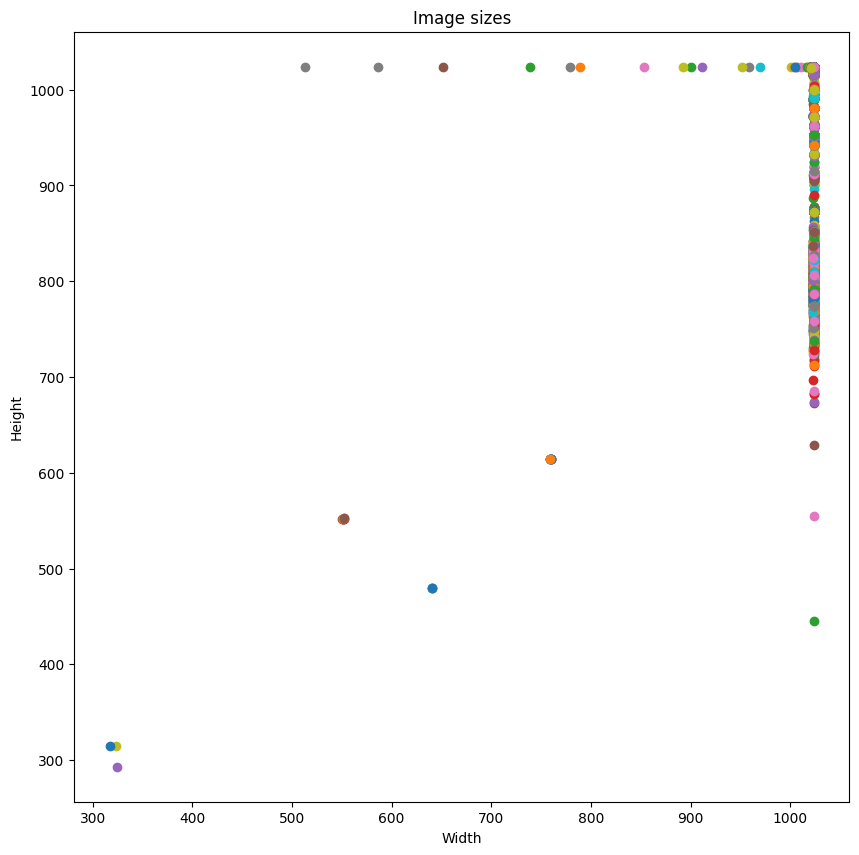

Lowest width: 317, lowest height: 293
Highest width: 1024, highest height: 1024
Average width: 1021.9101366896739, average height: 913.3560698335364


In [12]:
import matplotlib.pyplot as plt
from tqdm import tqdm

highest_width = 0
highest_height = 0

lowest_width = float("inf")
lowest_height = float("inf")

avg_width = 0
avg_height = 0

figure = plt.figure(figsize=(10, 10))

ran = range(1, len(train_dataset), 10)
for _ in tqdm(ran):
    img, label = train_dataset[_]
    size = img.size
    
    avg_width += size[0]
    avg_height += size[1]
    
    if size[0] < lowest_width:
        lowest_width = size[0]
    if size[1] < lowest_height:
        lowest_height = size[1]
    
    if size[0] > highest_width:
        highest_width = size[0]
    if size[1] > highest_height:
        highest_height = size[1]
    
    plt.scatter(size[0], size[1])
    

plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image sizes")
plt.show()
print(f"Lowest width: {lowest_width}, lowest height: {lowest_height}")
print(f"Highest width: {highest_width}, highest height: {highest_height}")
print(f"Average width: {avg_width / len(ran)}, average height: {avg_height / len(ran)}")

Average size is quite close to 1024x1024, but images will be resized to 256x256, to speed up training.
It looks like there is very litte images smaller than this size, so information loss should be minimal.

### Add transforms to the dataset

In [5]:
from pathlib import Path

import torchvision
transformations = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.ToTensor(),
])
train_dataset = torchvision.datasets.ImageFolder(root=str(Path(processed, 'train')), transform=transformations)
val_dataset = torchvision.datasets.ImageFolder(root=str(Path(processed, 'val')), transform=transformations)
test_dataset = torchvision.datasets.ImageFolder(root=str(Path(processed, 'test')), transform=transformations)

### Visualize some images from train dataset

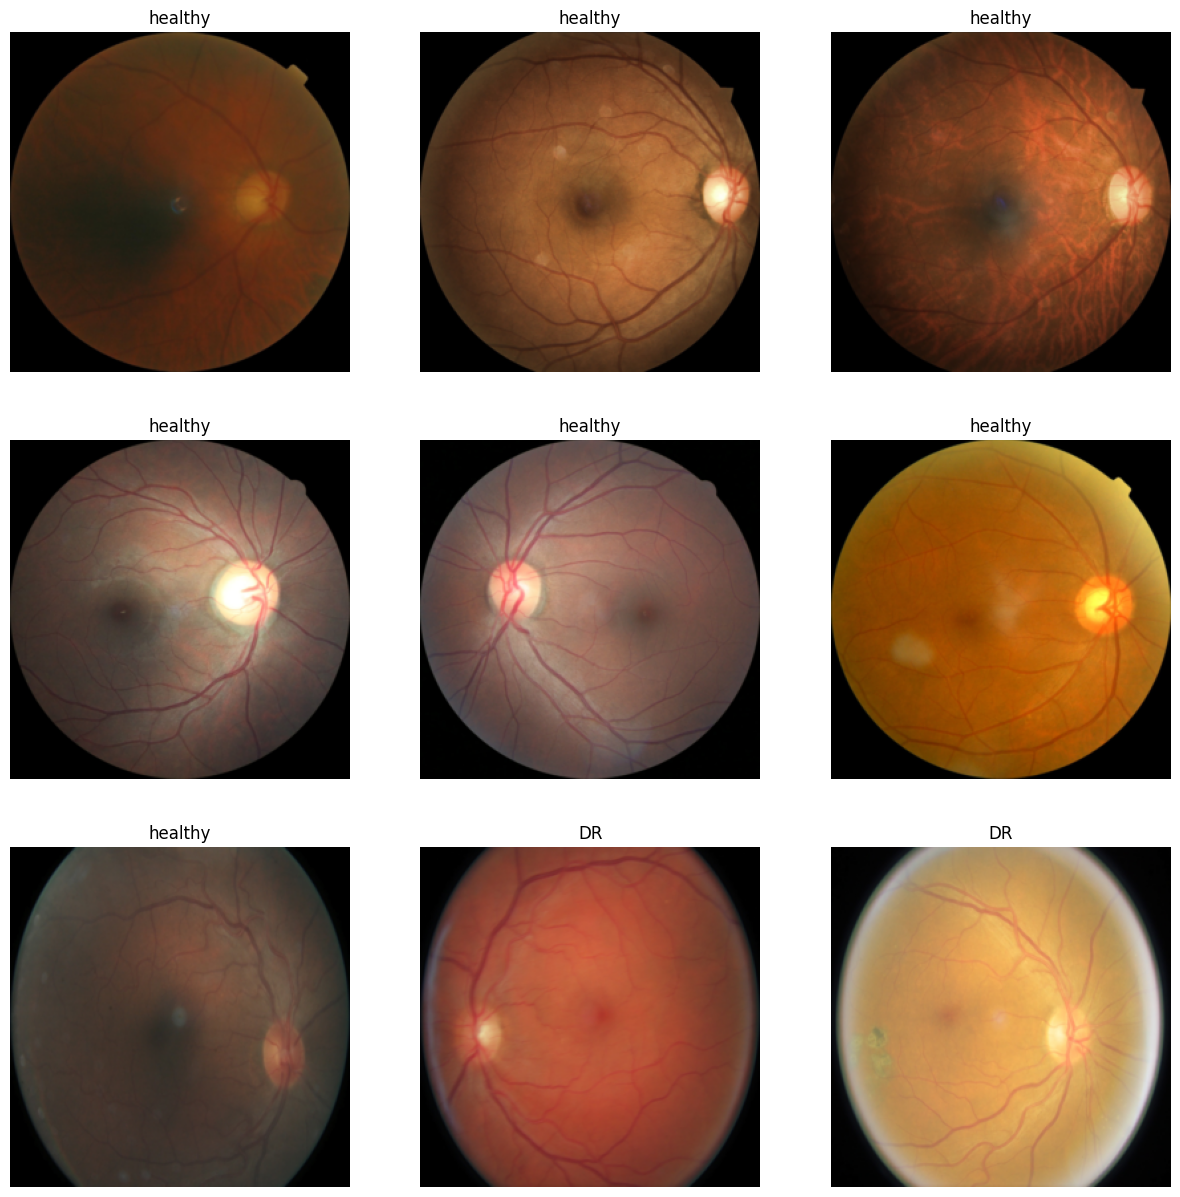

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

DR_CLASSES = {
    0: "healthy",
    1: "DR",
    2: "DR",
    3: "DR",
    4: "DR"
}

figure = plt.figure(figsize=(15, 15))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(DR_CLASSES[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    

# Dataloaders

In [17]:
import os
import torch
import torchvision

from pathlib import Path
from dotenv import load_dotenv

BATCH_SIZE = 8
LOADER_WORKERS = 8

load_dotenv()
root_data = os.getenv("KAGGLE_FILES_DIR")
dataset_path = Path(os.getcwd(), "..", root_data)
processed = Path(dataset_path, 'processed')


transformations = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(root=str(Path(processed, 'train')), transform=transformations)
val_dataset = torchvision.datasets.ImageFolder(root=str(Path(processed, 'val')), transform=transformations)
test_dataset = torchvision.datasets.ImageFolder(root=str(Path(processed, 'test')), transform=transformations)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=LOADER_WORKERS)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=LOADER_WORKERS)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=LOADER_WORKERS)


### Size of datasets

In [18]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 73890
Validation dataset size: 9235
Test dataset size: 9239


In [19]:
image, label = train_dataset[0]
print(image.shape[0])
print(label)

3
0


# Define classifier
### Using CNN with 3 convolutional layers and 2 fully connected layers.

In [20]:
import torch
import torch.nn as nn


class CNN(nn.Module):
    def __init__(self, input_size: torch.Size, initial_filters: int, out_classes: int, dropout: float = 0.25, device: str = "cpu", ):
        super(CNN, self).__init__()
        channels, _, _ = input_size
        self.device = device
        self.conv = nn.Sequential(
            nn.Conv2d(channels, initial_filters, kernel_size=3, stride=1, padding=1, device=self.device),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(initial_filters, initial_filters * 2, kernel_size=3, stride=1, padding=1, device=self.device),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(initial_filters * 2, initial_filters * 4, kernel_size=3, stride=1, padding=1, device=self.device),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.perceptron = nn.Sequential(
            nn.Linear(self._get_conv_out_shape(input_size), initial_filters * 8, device=self.device),
            nn.Dropout(dropout),
            nn.Linear(initial_filters * 8, out_classes, device=self.device),
        )
    
    def forward(self, x: torch.Tensor):
        x = x.to(self.device)
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.perceptron(x)
        return x
    
    def _get_conv_out_shape(self, input_size: torch.Size):
        with torch.no_grad():
            zeros = torch.zeros(*input_size, device=self.device)
            z = self.conv(zeros)
            z = torch.prod(torch.tensor(z.shape))
        return z


In [21]:
class EarlyStopper:
    def __init__(self, patience: int = 5, min_delta: float = 0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

For evaluation of the model, I will use accuracy and cross-entropy loss.

In [22]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def evaluate(
        model: nn.Module, 
        valid_loader: torch.utils.data.DataLoader, 
        loss_func: nn.Module, 
        epoch_no: int, 
        writer: torch.utils.tensorboard.SummaryWriter
):    
    model.eval()
    epoch_loss = 0
    correct_class = 0
    targets_list = []
    preds_list = []
    
    dataset_size = len(valid_loader.dataset)
    
    with torch.no_grad():
        device = model.device
        for inputs, targets in tqdm(valid_loader, desc="Evaluation: "):
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            pred_class = torch.argmax(output, dim=1)
            correct_class += (pred_class == targets).sum()
            loss = loss_func(output, targets)
            epoch_loss += loss.item() * inputs.size(0)
            
            # Count the number of targets and predictions
            targets_list.append(targets.cpu().numpy())
            preds_list.append(pred_class.cpu().numpy())
    
    avg_epoch_loss = epoch_loss / dataset_size
    accuracy = correct_class / dataset_size
    
    targets_np = np.concatenate(targets_list)
    preds_np = np.concatenate(preds_list)

    confusion_mat = confusion_matrix(targets_np, preds_np)
    precision = precision_score(targets_np, preds_np)
    recall = recall_score(targets_np, preds_np)
    f1 = f1_score(targets_np, preds_np)
    roc_auc = roc_auc_score(targets_np, preds_np)
    
    print(f"""Epoch: {epoch_no}
        Average epoch loss: {avg_epoch_loss}
        Confusion matrix: {confusion_mat}
        Accuracy: {accuracy}
        Precision: {precision:}
        Recall: {recall}
        F1: {f1}
        ROC AUC: {roc_auc}""")

    writer.add_scalar('Loss/train', avg_epoch_loss, epoch_no)
    writer.add_scalar('Accuracy/train', accuracy, epoch_no)
    writer.add_scalar('Precision/train', precision, epoch_no)
    writer.add_scalar('Recall/train', recall, epoch_no)
    writer.add_scalar('F1/train', f1, epoch_no)
    writer.add_scalar('ROC AUC/train', roc_auc, epoch_no)
    
    
    return avg_epoch_loss, accuracy, precision, recall, f1, roc_auc, confusion_mat

In [23]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

def train(
        model: nn.Module, 
        train_loader: torch.utils.data.DataLoader,
        valid_loader: torch.utils.data.DataLoader,
        max_epochs: int,
        optimizer: optim.Optimizer, 
        loss_func: nn.Module,
        patience: int = 3,
        min_delta: float = 0.001,
):
    
    writer = SummaryWriter('../runs/baseline_lr01_delta001_100eps')
    device = model.device
    early_stopping = EarlyStopper(patience=patience, min_delta=min_delta)
    best_avg_loss = float('inf')
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
    for epoch in range(1, max_epochs + 1):
        model.train()
        for inputs, targets in tqdm(train_loader, desc=f"Train epoch {epoch}: "):
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            predicted = model(inputs)
            loss = loss_func(predicted, targets)
            loss.backward()
            optimizer.step()
        
        avg_epoch_loss, accuracy, precision, recall, f1, roc_auc, confusion_mat = evaluate(model, valid_loader, loss_func, epoch, writer)
        
        lr_scheduler.step()
        
        if avg_epoch_loss < best_avg_loss:
            best_avg_loss = avg_epoch_loss
            torch.save(model.state_dict(), "../models/best_model_100eps.pt")
            print(f"Model saved on epoch {epoch}")
            
        if early_stopping.early_stop(avg_epoch_loss):
            print(f'''Early stopping on epoch {epoch}
            Validation loss: {avg_epoch_loss}
            Accuracy: {accuracy}
            Confusion Matrix: {confusion_mat}
            Precision: {precision}
            Recall: {recall}
            F1: {f1}
            ROC AUC: {roc_auc}''')
            break
    
    writer.close()


In [24]:
image, label = train_dataset[0]

DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

model_params = {
    "input_size": image.shape,
    "initial_filters": 8,
    "out_classes": len(train_dataset.classes),
    "device": DEVICE
}
cnn = CNN(**model_params)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.01)

n_epochs = 100

In [25]:
train(cnn, train_loader, val_loader, n_epochs, optimizer, loss_func)

Evaluation: 100%|██████████| 1155/1155 [01:04<00:00, 17.99it/s]


Epoch: 1
        Average epoch loss: 0.5674877212960202
        Confusion matrix: [[6710    4]
 [2403  118]]
        Accuracy: 0.7393611073493958
        Precision: 0.9672131147540983
        Recall: 0.046806822689408965
        F1: 0.08929247067726069
        ROC AUC: 0.5231055263283207
Model saved on epoch 1


Evaluation: 100%|██████████| 1155/1155 [01:02<00:00, 18.50it/s]


Epoch: 2
        Average epoch loss: 0.559562690734347
        Confusion matrix: [[6702   12]
 [2384  137]]
        Accuracy: 0.7405522465705872
        Precision: 0.9194630872483222
        Recall: 0.054343514478381594
        F1: 0.10262172284644194
        ROC AUC: 0.5262781021900398
Model saved on epoch 2


Evaluation: 100%|██████████| 1155/1155 [01:02<00:00, 18.53it/s]


Epoch: 3
        Average epoch loss: 0.5558980628097774
        Confusion matrix: [[6696   18]
 [2377  144]]
        Accuracy: 0.740660548210144
        Precision: 0.8888888888888888
        Recall: 0.057120190400634666
        F1: 0.1073425270219903
        ROC AUC: 0.5272196126265908
Model saved on epoch 3


Evaluation: 100%|██████████| 1155/1155 [01:02<00:00, 18.62it/s]


Epoch: 4
        Average epoch loss: 0.5543302914679341
        Confusion matrix: [[6694   20]
 [2374  147]]
        Accuracy: 0.7407687902450562
        Precision: 0.8802395209580839
        Recall: 0.058310194367314556
        F1: 0.109375
        ROC AUC: 0.5276656721017389
Model saved on epoch 4


Evaluation: 100%|██████████| 1155/1155 [01:02<00:00, 18.53it/s]


Epoch: 5
        Average epoch loss: 0.5621533129043559
        Confusion matrix: [[6704   10]
 [2381  140]]
        Accuracy: 0.7410936951637268
        Precision: 0.9333333333333333
        Recall: 0.055533518445061485
        F1: 0.10482965181579933
        ROC AUC: 0.5270220466815715


Evaluation: 100%|██████████| 1155/1155 [01:02<00:00, 18.49it/s]


Epoch: 6
        Average epoch loss: 0.5577538248391557
        Confusion matrix: [[6639   75]
 [2311  210]]
        Accuracy: 0.7416350841522217
        Precision: 0.7368421052631579
        Recall: 0.08330027766759222
        F1: 0.1496792587312901
        ROC AUC: 0.5360647947766022


Evaluation: 100%|██████████| 1155/1155 [01:03<00:00, 18.07it/s]


Epoch: 7
        Average epoch loss: 0.5508718272577315
        Confusion matrix: [[6703   11]
 [2381  140]]
        Accuracy: 0.7409853935241699
        Precision: 0.9271523178807947
        Recall: 0.055533518445061485
        F1: 0.10479041916167664
        ROC AUC: 0.5269475754274755
Model saved on epoch 7


Evaluation: 100%|██████████| 1155/1155 [01:04<00:00, 17.92it/s]


Epoch: 8
        Average epoch loss: 0.5463775851594866
        Confusion matrix: [[6686   28]
 [2344  177]]
        Accuracy: 0.743151068687439
        Precision: 0.8634146341463415
        Recall: 0.07021023403411344
        F1: 0.12986060161408658
        ROC AUC: 0.533019921902371
Model saved on epoch 8


Evaluation: 100%|██████████| 1155/1155 [01:02<00:00, 18.41it/s]


Epoch: 9
        Average epoch loss: 0.548484729926652
        Confusion matrix: [[6660   54]
 [2312  209]]
        Accuracy: 0.7438007593154907
        Precision: 0.7946768060836502
        Recall: 0.08290360967869893
        F1: 0.15014367816091953
        ROC AUC: 0.5374303571181699


Evaluation: 100%|██████████| 1155/1155 [01:03<00:00, 18.29it/s]


Epoch: 10
        Average epoch loss: 0.5456078811794213
        Confusion matrix: [[6679   35]
 [2324  197]]
        Accuracy: 0.7445587515830994
        Precision: 0.8491379310344828
        Recall: 0.07814359381197937
        F1: 0.143116600072648
        ROC AUC: 0.5364653030126326
Model saved on epoch 10


Evaluation: 100%|██████████| 1155/1155 [01:02<00:00, 18.54it/s]


Epoch: 11
        Average epoch loss: 0.5413075899974552
        Confusion matrix: [[6645   69]
 [2264  257]]
        Accuracy: 0.7473741173744202
        Precision: 0.7883435582822086
        Recall: 0.10194367314557715
        F1: 0.18054092026694765
        ROC AUC: 0.5458333200401702
Model saved on epoch 11


Evaluation: 100%|██████████| 1155/1155 [01:02<00:00, 18.55it/s]


Epoch: 12
        Average epoch loss: 0.5456584080981124
        Confusion matrix: [[6679   35]
 [2326  195]]
        Accuracy: 0.7443421483039856
        Precision: 0.8478260869565217
        Recall: 0.07735025783419278
        F1: 0.14176663031624864
        ROC AUC: 0.5360686350237392


Evaluation: 100%|██████████| 1155/1155 [01:02<00:00, 18.56it/s]


Epoch: 13
        Average epoch loss: 0.545461112702932
        Confusion matrix: [[6628   86]
 [2278  243]]
        Accuracy: 0.7440173029899597
        Precision: 0.7386018237082067
        Recall: 0.096390321301071
        F1: 0.1705263157894737
        ROC AUC: 0.5417906327982864


Evaluation: 100%|██████████| 1155/1155 [01:02<00:00, 18.50it/s]


Epoch: 14
        Average epoch loss: 0.5383251367127759
        Confusion matrix: [[6521  193]
 [2115  406]]
        Accuracy: 0.7500812411308289
        Precision: 0.67779632721202
        Recall: 0.1610472034906783
        F1: 0.2602564102564103
        ROC AUC: 0.5661506497048268
Model saved on epoch 14


Evaluation: 100%|██████████| 1155/1155 [01:02<00:00, 18.48it/s]


Epoch: 15
        Average epoch loss: 0.5440506271820296
        Confusion matrix: [[6660   54]
 [2287  234]]
        Accuracy: 0.7465078234672546
        Precision: 0.8125
        Recall: 0.09282030940103134
        F1: 0.1666073335706657
        ROC AUC: 0.542388706979336


Evaluation: 100%|██████████| 1155/1155 [01:02<00:00, 18.40it/s]


Epoch: 16
        Average epoch loss: 0.5531105603810963
        Confusion matrix: [[6670   44]
 [2317  204]]
        Accuracy: 0.7443421483039856
        Precision: 0.8225806451612904
        Recall: 0.08092026973423244
        F1: 0.14734561213434452
        ROC AUC: 0.5371833996868958


Evaluation: 100%|██████████| 1155/1155 [01:03<00:00, 18.27it/s]

Epoch: 17
        Average epoch loss: 0.5512703391882169
        Confusion matrix: [[6667   47]
 [2315  206]]
        Accuracy: 0.7442339062690735
        Precision: 0.8142292490118577
        Recall: 0.08171360571201904
        F1: 0.14852198990627252
        ROC AUC: 0.5373566539135013
Early stopping on epoch 17
            Validation loss: 0.5512703391882169
            Accuracy: 0.7442339062690735
            Confusion Matrix: [[6667   47]
 [2315  206]]
            Precision: 0.8142292490118577
            Recall: 0.08171360571201904
            F1: 0.14852198990627252
            ROC AUC: 0.5373566539135013


Results are not satisfying, but baseline is established.

Validation loss: 0.5512703391882169
            Accuracy: 0.7442339062690735
            Confusion Matrix: [
                [6667   47]
                [2315  206]
            ]
            Precision: 0.8142292490118577
            Recall: 0.08171360571201904
            F1: 0.14852198990627252
            ROC AUC: 0.5373566539135013

## Baseline summary

- CNN model:
    - 3 convolutional layers, each with padding 1, kernel size 3, stride 1
        - ReLU activation function after each convolutional layer
        - max pooling after each convolutional layer, kernel size 2
        - 8 initial filters
    - 2 fully connected layers
    - Dropout of 0.25 between FC layers
- Images: 
    - rezised to 256x256 
    - no augmentation
    - no normalization
    - no grayscale conversion
    - 3 channels
    - 80%/10%/10% split
- Dataloaders:
    - Batch size of 8
    - 8 workers
    - Shuffled
    - No pin memory
    - No drop last
Training and validation:
    - use GPU available (CUDA or MPS)
    - max 100 epochs
    - Learning rate of 0.01
    - Early stopping with patience of 3 epochs and minimum delta of 0.001
    - Loss function: Cross-entropy
    - Optimizer: SGD
    - Scheduler: StepLR with step size of 20 and gamma of 0.1



More experiments with image transformations and model hyperparameters will be continued in respective notebooks.